In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import os
import tqdm
import random
from keras.preprocessing.image import load_img
warnings.filterwarnings('ignore')
import zipfile

/Users/kazimir/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


mkdir -p data

wget "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip" -O data/cats_and_dogs.zip

ls -lh data/cats_and_dogs.zip

In [3]:
input_path = []
label = []

for class_ in os.listdir('PetImages/'):
    for path in os.listdir('PetImages/' + class_):
        if class_ == 'Cat' :
            label.append(0)
        else :
            label.append(1)
        input_path.append(os.path.join('PetImages/',class_, path))
print (input_path[0],label[0])


PetImages/Cat/9733.jpg 0


In [4]:
len(label)
len(input_path)

25002

In [5]:
df = pd.DataFrame()
df['images'] = input_path
df['label'] = label

df = df.sample(frac=1).reset_index(drop=True)
df.head(10)

images  label
0   PetImages/Dog/3512.jpg      1
1   PetImages/Cat/8125.jpg      0
2   PetImages/Dog/7565.jpg      1
3   PetImages/Dog/9607.jpg      1
4   PetImages/Dog/6110.jpg      1
5   PetImages/Dog/6375.jpg      1
6   PetImages/Dog/4202.jpg      1
7    PetImages/Cat/758.jpg      0
8   PetImages/Cat/8152.jpg      0
9  PetImages/Cat/11360.jpg      0

In [33]:
#delete db files
for i in df['images']:
    if '.jpg' not in i:
        print(i)

PetImages/Dog/Thumbs.db
PetImages/Cat/Thumbs.db


In [34]:
import PIL
l = []
for image in df['images']:
    try:
        img = PIL.Image.open(image)
    except:
        l.append(image)
l

['PetImages/Dog/Thumbs.db',
 'PetImages/Dog/11702.jpg',
 'PetImages/Cat/666.jpg',
 'PetImages/Cat/Thumbs.db']

In [35]:
df = df[df['images']!='PetImages/Dog/Thumbs.db']
df = df[df['images']!='PetImages/Cat/Thumbs.db']
df = df[df['images']!='PetImages/Cat/666.jpg']
df = df[df['images']!='PetImages/Dog/11702.jpg']
len(df)

24998

In [36]:
#EDA
plt.figure(figsize = (25,25))
temp = df[df['label'] == 1]['images']
start = random.randint(0, len(temp)-25)
files = temp[start:start+25]

for index,file in enumerate(files):
    plt.subplot(5,5,index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title('Dogs')
    plt.axis('off')

ValueError: empty range for randrange() (0, -24, -24)

<Figure size 2500x2500 with 0 Axes>

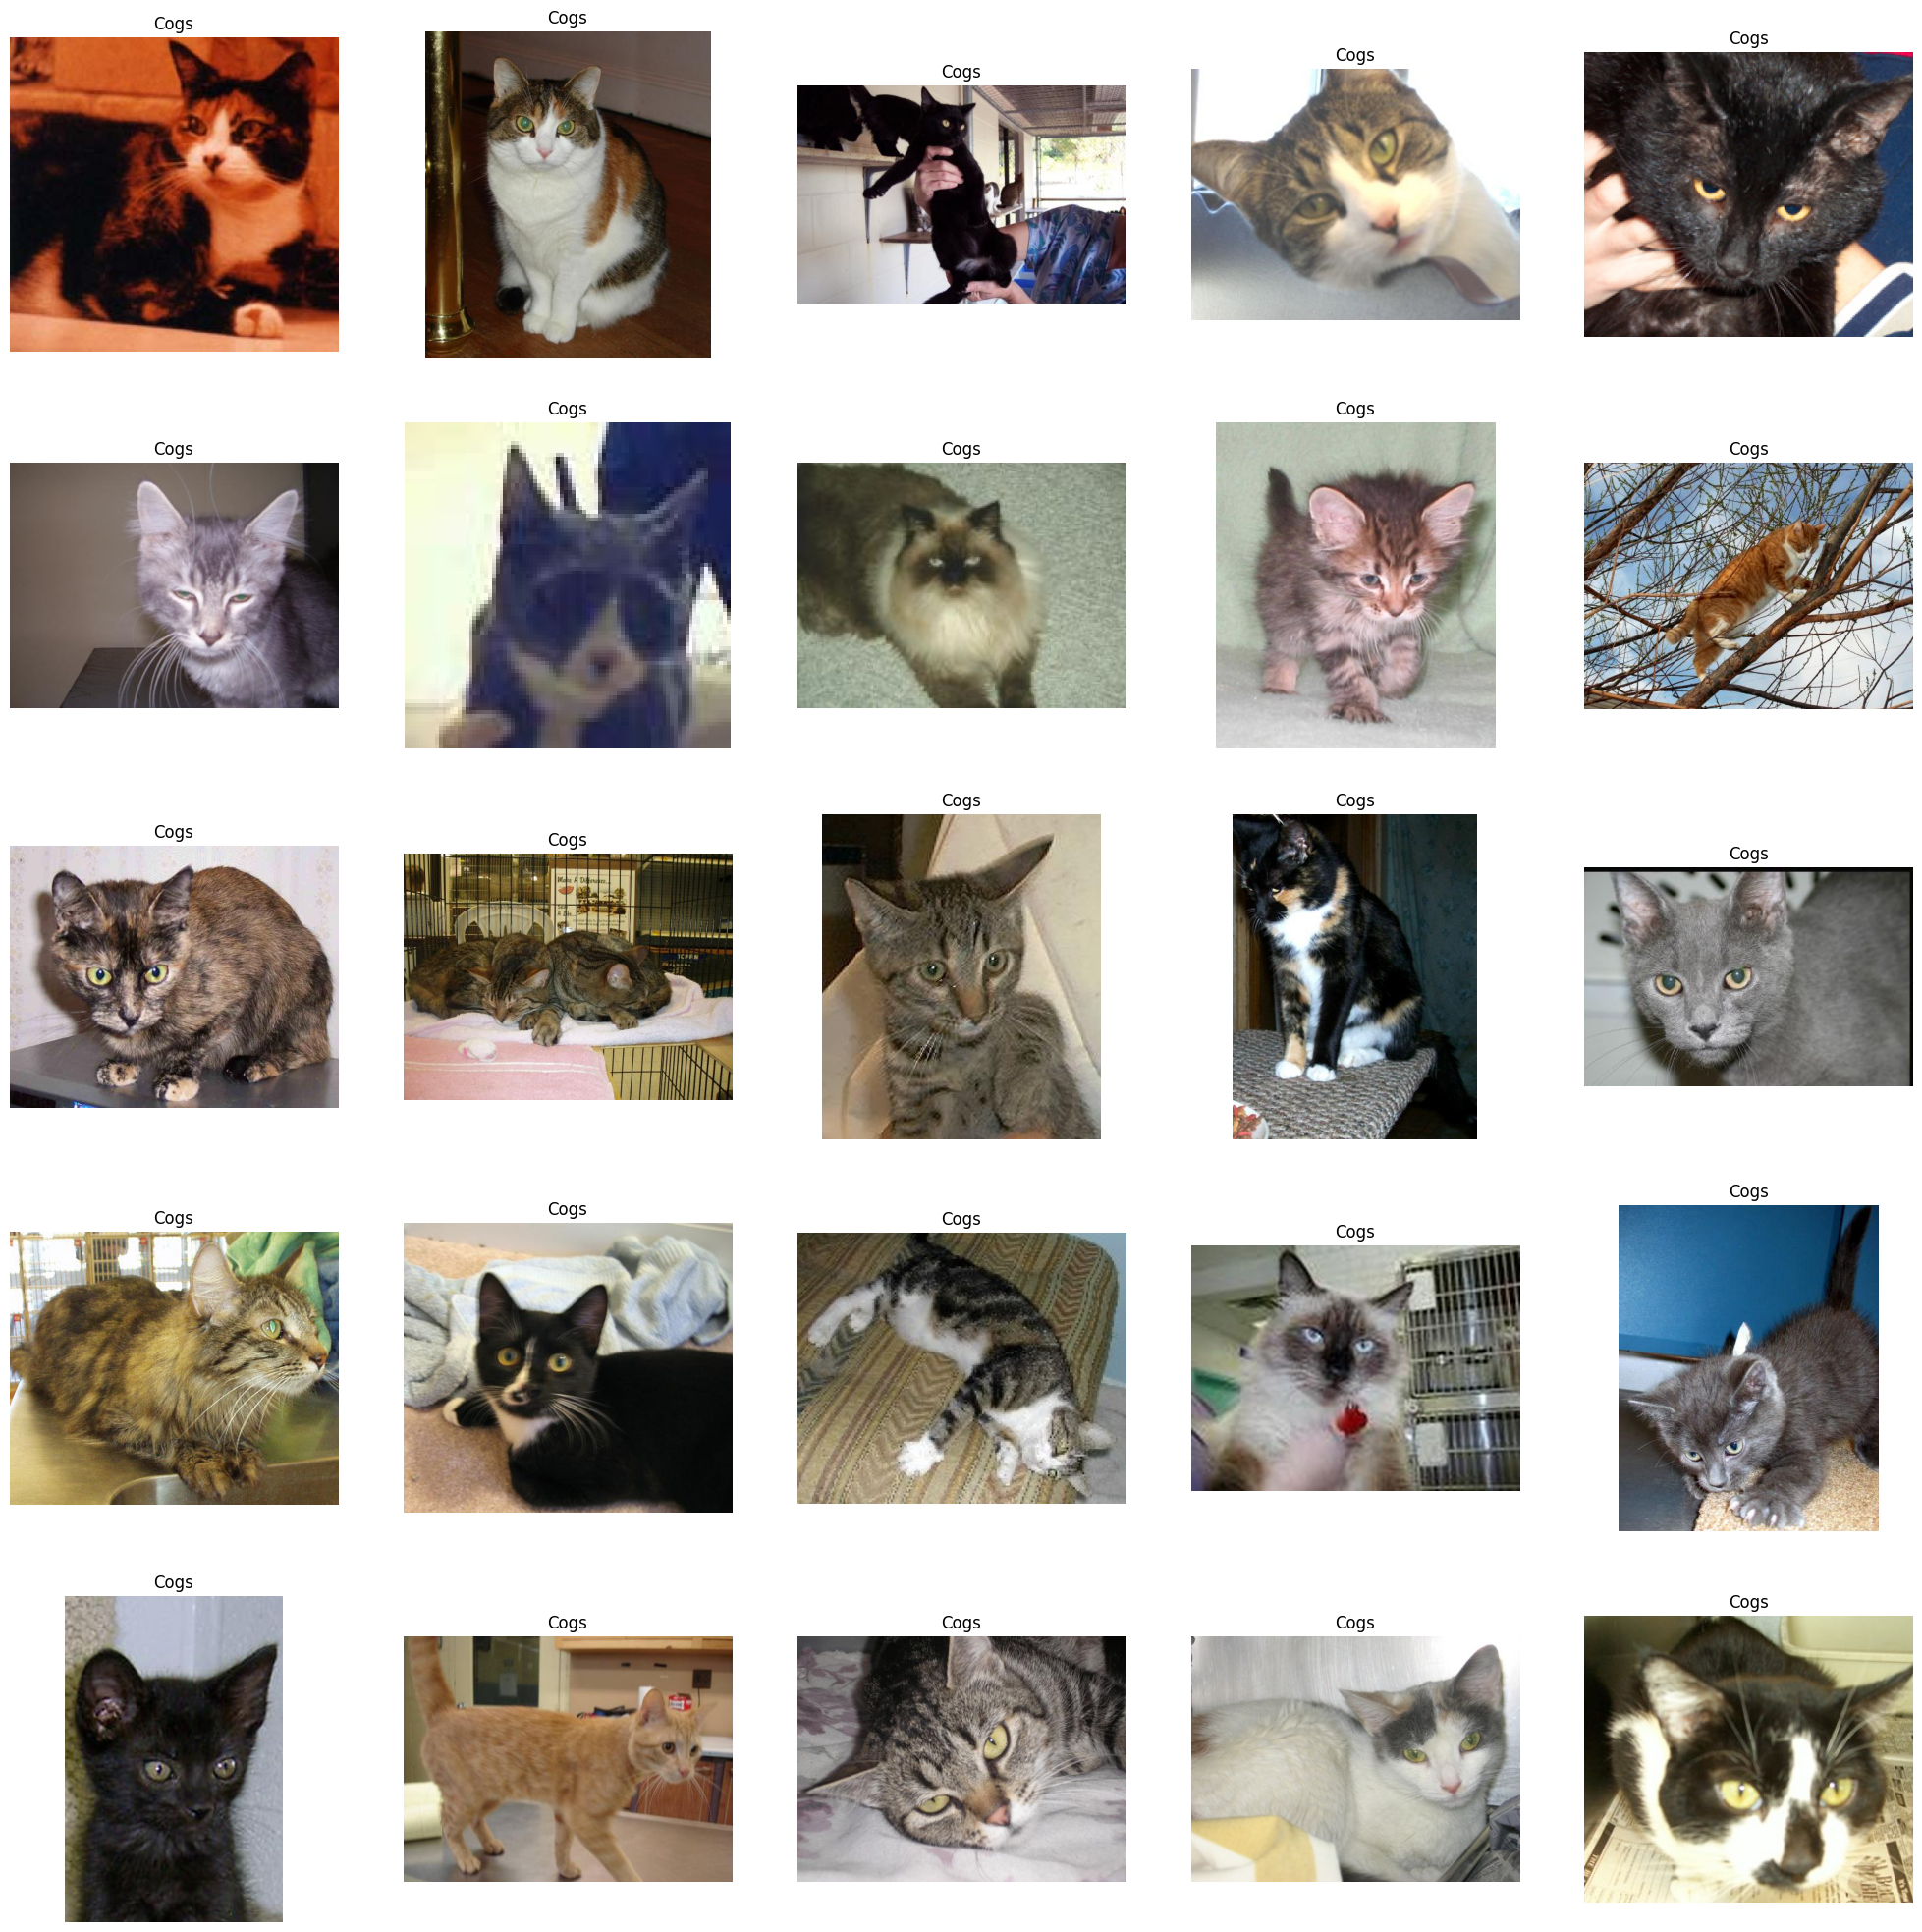

In [11]:
plt.figure(figsize = (25,25))
temp = df[df['label'] == 0]['images']
start = random.randint(0, len(temp)-25)
files = temp[start:start+25]

for index,file in enumerate(files):
    plt.subplot(5,5,index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title('Cogs')
    plt.axis('off')

<Axes: xlabel='label', ylabel='count'>

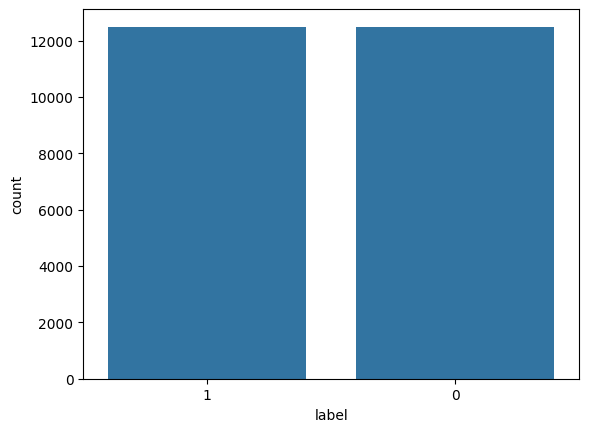

In [37]:
import seaborn as sns
sns.countplot(x='label', data=df)

In [38]:
#input split
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2, random_state=42)

In [39]:
train.head()

images label
23289   PetImages/Dog/5024.jpg     1
17784    PetImages/Cat/300.jpg     0
1020    PetImages/Dog/4882.jpg     1
12646  PetImages/Cat/10142.jpg     0
1533    PetImages/Cat/8699.jpg     0

In [40]:
#Create DataGenerator for Images
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_generator = ImageDataGenerator(
    rescale=1./255, #normalization
    #augmentation of imgs - avoid overfitting
    rotation_range=40,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_generator = ImageDataGenerator(rescale=1./255)

df['label'] = df['label'].astype('str')
train_iterator = train_generator.flow_from_dataframe(
    train,
    x_col = 'images',
    y_col = 'label',
    target_size = (128, 128),
    batch_size = 128,
    class_mode = 'binary')

val_iterator = val_generator.flow_from_dataframe(
    test,
    x_col = 'images',
    y_col = 'label',
    target_size = (128, 128),
    batch_size = 128,
    class_mode = 'binary')

Found 19998 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


In [41]:
#model creation
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense

model = Sequential([
    Conv2D(16, (3,3), activation = 'relu', input_shape = (128, 128, 3)),
    MaxPool2D(pool_size=(2,2)),
    Conv2D(32, (3,3), activation = 'relu'),
    MaxPool2D(pool_size=(2,2)),
    Conv2D(64, (3,3), activation = 'relu'),
    MaxPool2D(pool_size=(2,2)),
    Flatten(),
    Dense(128, activation = 'relu'),
    Dense(1, activation = 'sigmoid'),
])

In [42]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 126, 126, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 63, 63, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 61, 61, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,629,473 (6.22 MB)

 Trainable params: 1,629,473 (6.22 MB)

 Non-trainable params: 0 (0.00 B)

In [43]:
history = model.fit(train_iterator, epochs = 50, validation_data = val_iterator)

Epoch 1/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 58s 361ms/step - accuracy: 0.5591 - loss: 0.6886 - val_accuracy: 0.7092 - val_loss: 0.5612
Epoch 2/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 54s 342ms/step - accuracy: 0.6898 - loss: 0.5815 - val_accuracy: 0.7268 - val_loss: 0.5499
Epoch 3/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 52s 328ms/step - accuracy: 0.7376 - loss: 0.5229 - val_accuracy: 0.7812 - val_loss: 0.4684
Epoch 4/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 50s 317ms/step - accuracy: 0.7625 - loss: 0.4925 - val_accuracy: 0.8010 - val_loss: 0.4399
Epoch 5/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 51s 326ms/step - accuracy: 0.7811 - loss: 0.4634 - val_accuracy: 0.8100 - val_loss: 0.4224
Epoch 6/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 55s 352ms/step - accuracy: 0.7886 - loss: 0.4530 - val_accuracy: 0.8128 - val_loss: 0.4169
Epoch 7/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 53s 334ms/step - accuracy: 0.8049 - loss: 0.4234 - val_accuracy: 0.8286 - val_loss: 0.3911
Epoch 8/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 53s 339ms/step - accuracy: 0.8056 - loss: 0

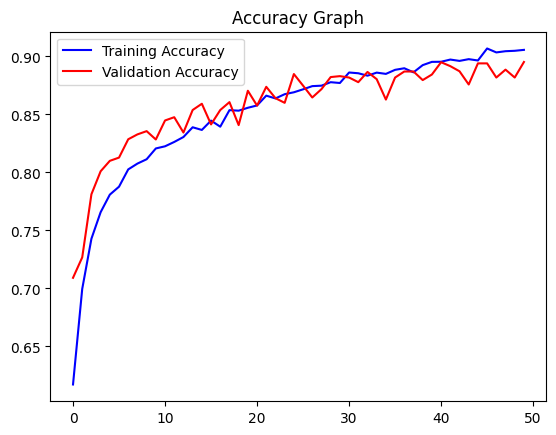

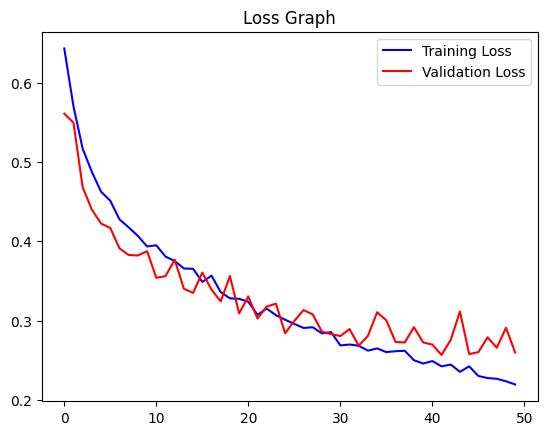

In [44]:
#result visualization
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

In [57]:
image_path = "insert path to image"
img = load_img(image_path, target_size=(128, 128))
plt.imshow(img)
img = np.array(img)
img = img / 255.0 # normalize the image
img = img.reshape(1, 128, 128, 3) # reshape for prediction
pred = model.predict(img)
if pred[0] > 0.5:
    label = 'Dog'
else:
    label = 'Cat'
print(label)
print (pred[0])

FileNotFoundError: [Errno 2] No such file or directory: 'insert path to image'